In [1]:
import git
repo = git.Repo('.', search_parent_directories=True)
repo_loc = repo.working_tree_dir

import os
import sys
from pathlib import Path

sys.path.append(repo_loc)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.covid19_plot_func import plot_state_num, plot_death_cause, plot_death_cumsum, plot_death_icu_rate
from src.covid19_prob_parameter import P_matrix # TODO, delete
# from src.covid19_prob_parameter import get_prob_matrix # TODO, add back
from src.covid19_model import run_model

from src.covid19_region_attr import create_region
from src import conf_helper as cf

from importlib import reload


In [2]:
config_model_param_file = 'model_param_v1.yaml'
model_config = cf.CovidConf(project_dir=repo_loc, config_file=config_model_param_file)
# init_P_matrix = get_prob_matrix(model_config)

In [3]:
config_region_file = 'lombardy_20200417.yaml'
# config = cf.CovidConf(project_dir=repo_loc, config_file=config_file, config_dir='config/region_model')
region = create_region(config_region_file)

In [4]:
print("region_name: ", region.region_name)
print("country: ", region.country)
print("Daily cases: ", region.daily_case)
print("Daily accumulated cases: ", region.acc_case)
print("Population: ", region.pop)
print("Population ratio: ", region.pop_ratio)
print("Estimated number of ICU: ", region.t_icu_est)
print("Number of ICU required: ", region.t_icu_ade)
print("Number of deaths: ", region.n_death)

region_name:  Lombardy
country:  Italy
Daily cases:  [   0    0   15   40   57   61   67   65   98  128   84  369  270  266
  300  431  361  808  769 1280  322 1489 1445 1095 1865 1587 1377 1571
 1493 2171 2380 3251 1691 1555 1942 1643 2543 2409 2117 1592 1154 1047
 1565 1292 1455 1598 1337 1079  791 1089 1388 1246 1544 1460 1262 1012
  827  941 1041]
Daily accumulated cases:  [    0     0    15    55   112   173   240   305   403   531   615   984
  1254  1520  1820  2251  2612  3420  4189  5469  5791  7280  8725  9820
 11685 13272 14649 16220 17713 19884 22264 25515 27206 28761 30703 32346
 34889 37298 39415 41007 42161 43208 44773 46065 47520 49118 50455 51534
 52325 53414 54802 56048 57592 59052 60314 61326 62153 63094 64135]
Population:  [ 884414  982354 1187594 1591034 1566175  961237 1182159  994236  711371]
Population ratio:  [0.0879089  0.09764393 0.11804436 0.15814545 0.15567452 0.09554495
 0.11750413 0.09882498 0.07070879]
Estimated number of ICU:  1174
Number of ICU require

In [5]:
###########################################
# Choose the region to test the model with
###########################################
n_days = len(region.daily_case) + 50

##### Setting hopsital beds, ICU and ventilator numbers #####

t_hosp_bed = 2000 # Assuming there is enough number of hospital beds (not ICU beds)

# Set the t_icu number
# Can set it to region.t_icu_est (estimated available ICU avaiable for the region), region.t_icu_ade (adequate ICU number for the region) or any numbers one wants
t_icu = region.t_icu_est

# Initial number of ICU beds. If t_icu_portion is a list, then will run with multiple tests with different t_icu_portion
# t_icu_portion = [1/10, 1/5, 1/2, 1]
# t_icu_portion = np.arange(0.0, 1.01, 0.01)
t_icu_portion = ""


if t_icu_portion !="":
    t_icu = (np.array(t_icu_portion)*t_icu).round()
else:
    t_icu = [t_icu]
t_vent = (np.array(t_icu)*0.6).round() # Initial number of ventilators

############
# Run model
############
list_df_infected = []
list_df_death_cause = []

print("Run model for region: ", region.region_name)
list_df_infected, list_df_death_cause = run_model(region.daily_case, region.pop_ratio, n_days, P_matrix, t_hosp_bed, t_icu, t_vent, model_config) # TODO, remove P_matrix

Run model for region:  Lombardy
t_icu:  1174
Running model for Day 0...
Running model for Day 10...
Running model for Day 20...
Running model for Day 30...
Running model for Day 40...
Running model for Day 50...
Running model for Day 60...
Running model for Day 70...
Running model for Day 80...
Running model for Day 90...
Running model for Day 100...
Finished running model for t_icu value of 1174



## Plotting

#### Number of patients in different state plot (plot_state_num)

In [6]:
from src import covid19_plot_func
reload(covid19_plot_func)
from src.covid19_plot_func import plot_state_num, plot_death_cause, plot_death_cumsum, plot_death_icu_rate

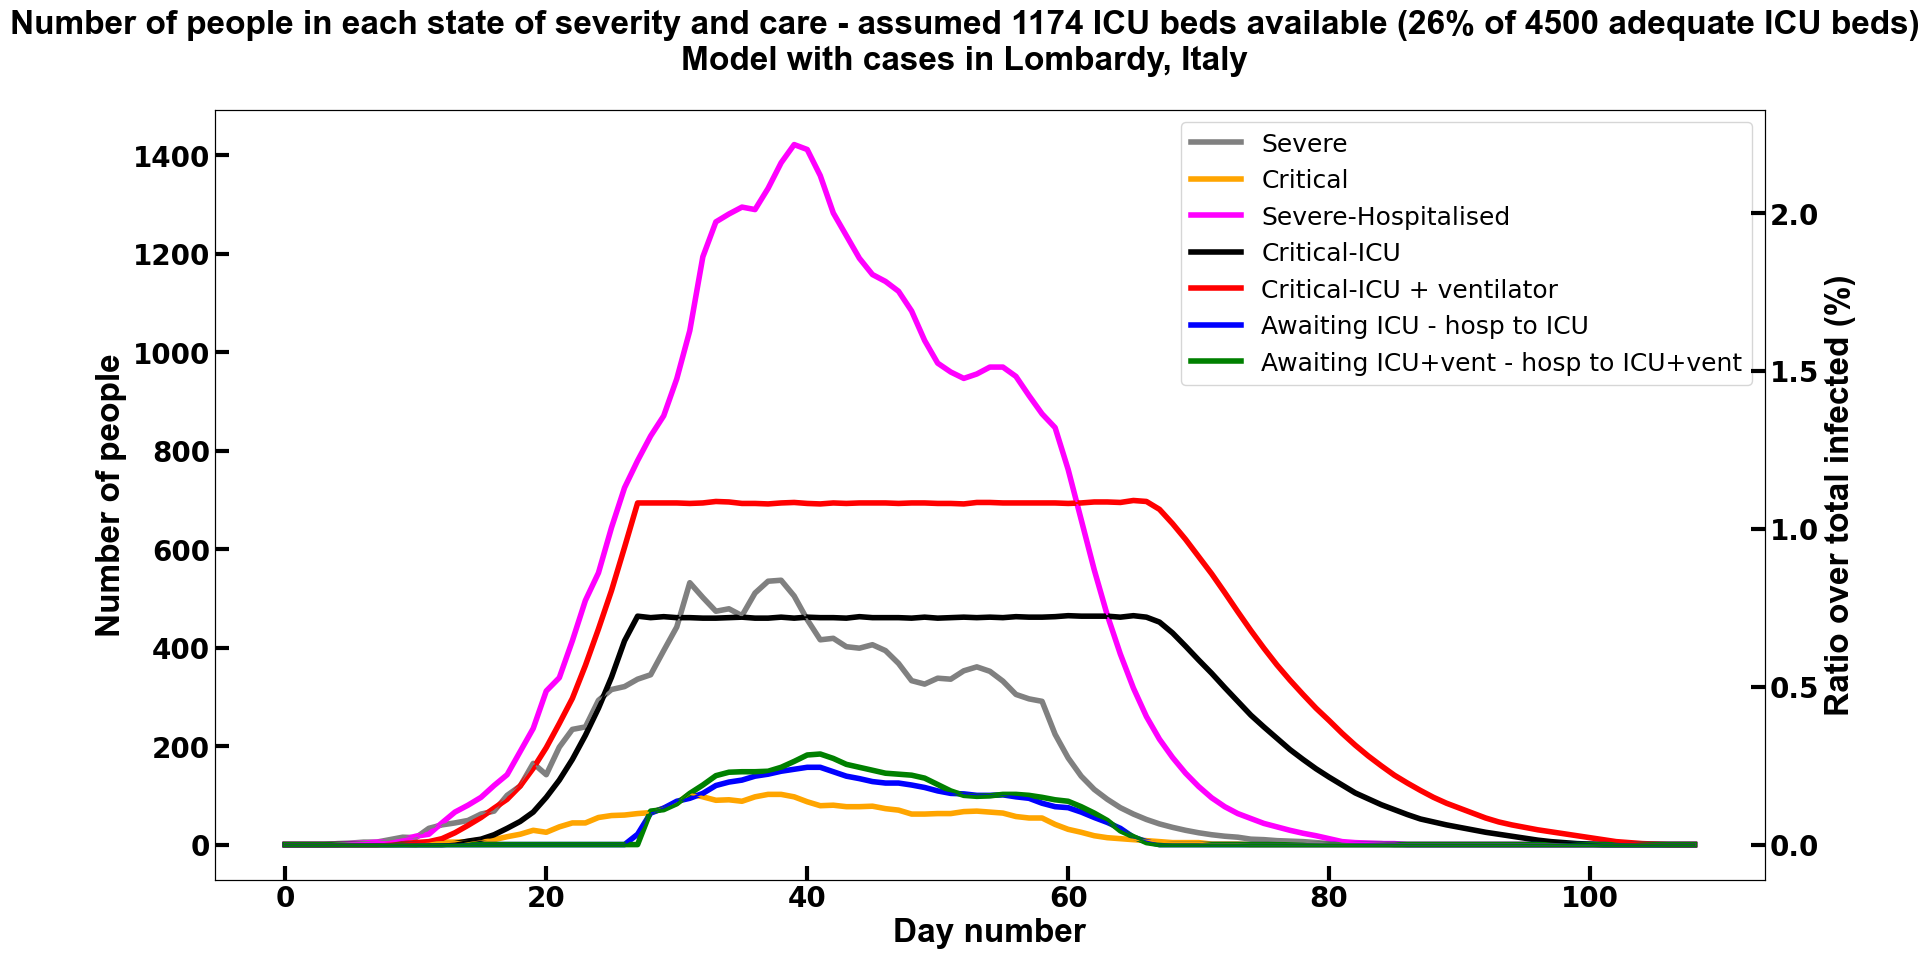

In [7]:
df_infected = list_df_infected[0]
plot_state_num(df_infected, region.daily_case.sum(), region.get_plot_title('plot_state_num', t_icu[0]))

### Number of deaths due to different causes over time

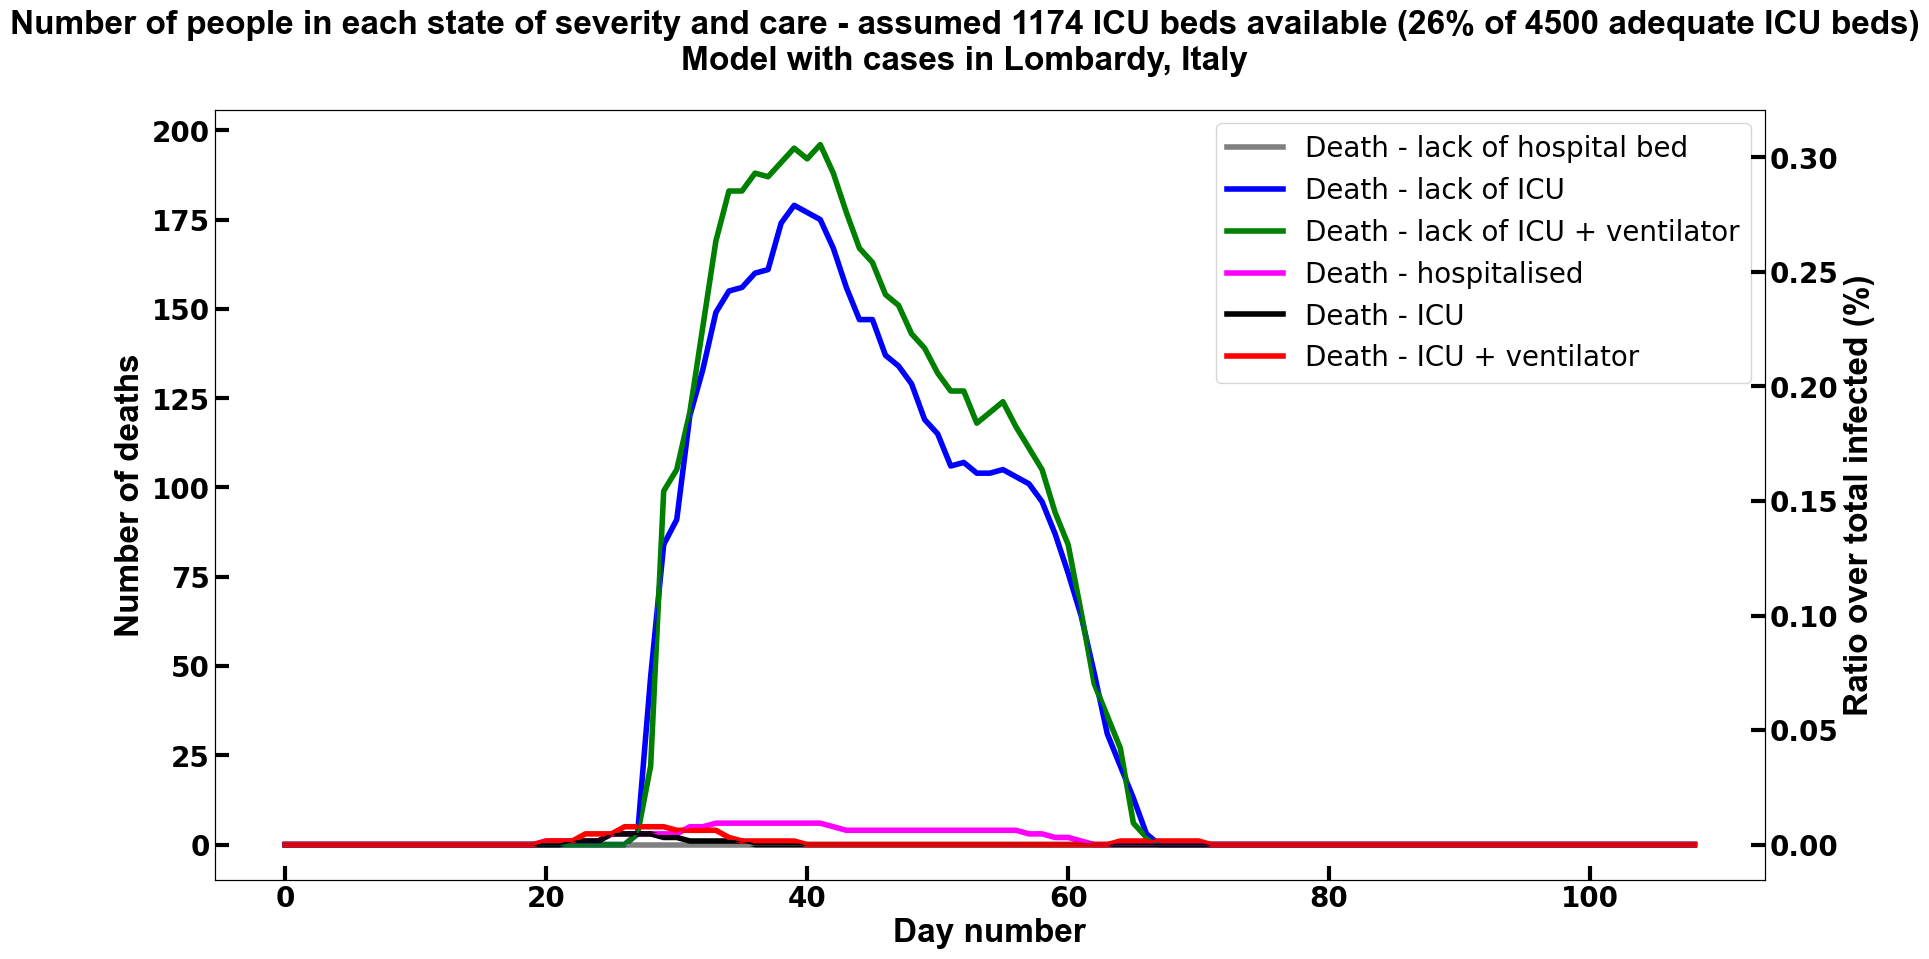

In [8]:
df_death_cause = list_df_death_cause[0]
plot_death_cause(df_death_cause, region.daily_case.sum(), region.get_plot_title('plot_death_acc', t_icu[0]))

### Accumulated number of deaths due to different cuases over time

(<Figure size 2000x1000 with 2 Axes>,
 <Axes: xlabel='Day number', ylabel='Number of deaths'>,
 <Axes: ylabel='Ratio over total infected (%)'>)

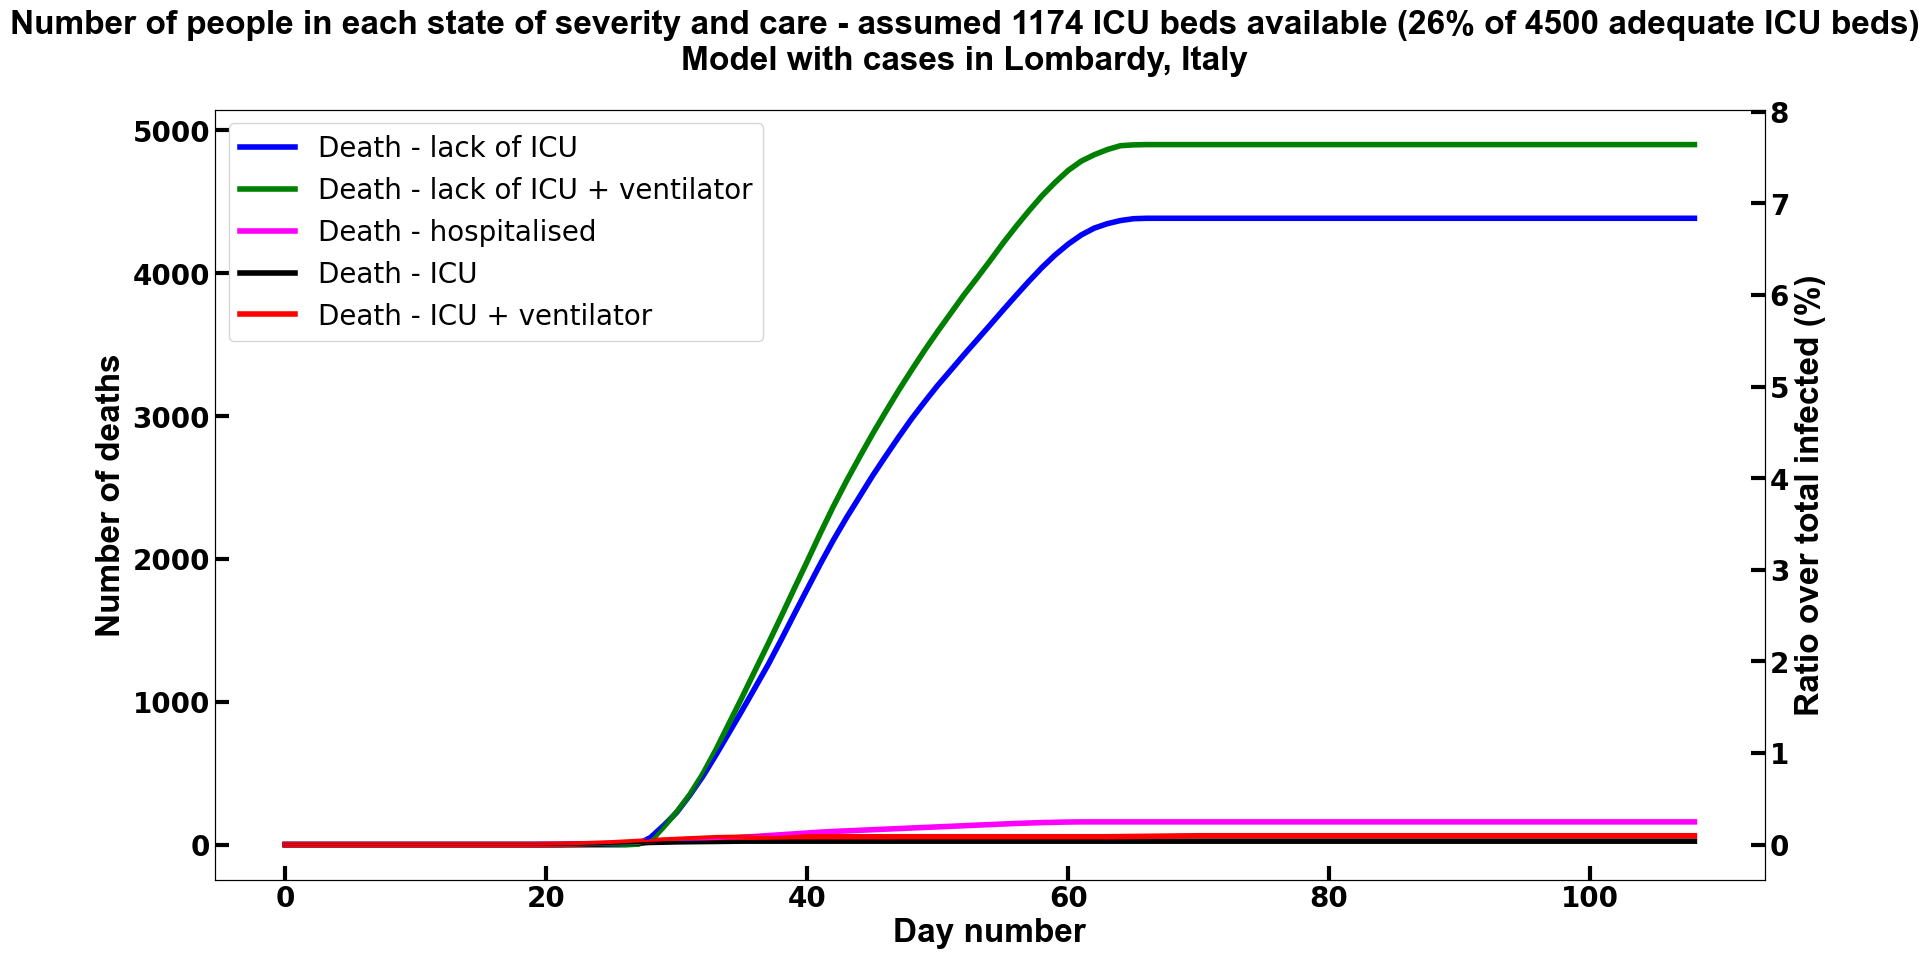

In [9]:
plot_death_cumsum(df_death_cause, region.daily_case.sum(), region.get_plot_title('plot_death_acc', t_icu[0]))